<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/transfer_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import requests 
plt.ion()   # interactive mode

In [0]:
r = requests.get("https://download.pytorch.org/tutorial/hymenoptera_data.zip")
with open("/content/hymenoptera_data.zip", 'wb') as f:
  f.write(r.content)
f.close()

In [0]:
!unzip -q hymenoptera_data.zip 

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



(228, 906, 3)


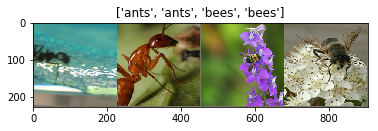

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    print(inp.shape)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
import torch
import torch.nn as nn
import torch.optim
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self,inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
    super(BasicBlock, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    if groups != 1 or base_width != 64:
      raise ValueError('BasicBlock only supports groups=1 and base_width=64')
    if dilation > 1:
      raise NotImplemented("Dilation > 1 not supported in BasicBlock")
    # Both self.conv1 and self.downsample layers downsample the input when stride != 1      
    self.conv1 = conv3x3(in_planes, out_planes, stride)
    self.bn1 = norm_layer(planes)
    self.relu = nn.ReLU(inplace = True)
    
    self.conv2 = conv3x3(in_planes, out_planes, stride)
    self.bn2 = norm_layer(planes)
    self.downsample = downsample
    self.stride = stride
    
  def forward(self,x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    
    if self.downsample is not None:
      identity = self.downsample(x)
    
    out += identity
    out = self.relu(out)
    
    return out

class Bottleneck(nn.Module):
  expansion = 4
  
  def __init__(self,inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
    super(Bottleneck, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    width = int(planes * (base_width / 64.)) * groups
    
    self.conv1 = conv1x1(in_planes, width)
    self.bn1 = norm_layer(width)
    
    self.conv2 = conv3x3(width, width, stride,groups, dilation)
    self.bn2 = norm_layer(width)
        
    self.conv3 = conv1x1(width, planes * self.expansion)
    self.bn3 = norm_layers(planes * self.expansion)
    self.relu = nn.ReLU(inplace = True)
    self.downsample = downsample
    self.stride = stride
  
  def forward(self, x):
    identity = x
    
    output = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)
    
    if self.downsample is not None:
      identity = self.downsample(x)
      
    out+=  identity
    out = self.relu(out)
    return out
  
class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
               groups=1, width_per_group=64, replace_stride_with_dilation=None,
               norm_layer=None):
    super(ResNet,self).__init__()
    if(norm_lay is None):
      norm_layer = nn.BatchNorm2d
    self._norm_layer = norm_layer
    self.inplanes = 64
    self.dilation = 1
    
    if replace_stride_with_dilation is None :
      replace_stride_with_dilation = [False, False, False]
    if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
    
    self.groups = groups
    self.base_width = width_per_group
    
    self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias= False)
    self.bn1 = norm_layer(self.inplanes)
    self.relu = nn.ReLU(inplace = True)
    self.maxpool = nn.MaxPool2d(kernel_size=3 , stride=2 , padding=1)
    self.layer1 = self._make_layer(block, 64, layer[0])
    self.layer2 = self._make_layer(block,128, layer[1], stride=2, dilate = replace_stride_with_dilation[0])
    self.layer3 = self._make_layer(block,256, layer[2], stride=2, dilate = replace_stride_with_dilation[1])
    self.layer4 = self._make_layer(block,512, layer[3], stride=2, dilate = replace_stride_with_dilation[2])
    
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512 * block.expansion, num_classes)
    
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
   # Zero-initialize the last BN in each residual branch,
   # so that the residual branch starts with zeros, and each residual block behaves like an identity.
    if zero_init_residual:
      for m in self.modules():
        if isinstance(m, Bottleneck):
          nn.init.constant_(m.bn3.weight, 0)
        elif isinstance(m, BasicBlock):
          nn.init.constant_(m.bn2.weight, 0)
  def _make_layer(self, block, planes, blocks, stride = 1, dilate = False):
    norm_layer = self._norm_layer
    downsample = None
    previous_dilation = self.dilation
    if dilate:
      self.dilation *= stride
      stride = 1
    if stride != 1 or self.inplanes != planes * block.expansion:
      downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
    self.inplanes = planes * block.expansion
    for _ in range(1, blocks):
      layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

    return nn.Sequential(*layers)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.size(0), -1)
    x = self.fc(x)

    return x

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {},'.format(class_names[preds[j]] ))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [29]:
model_ft = models.resnet50(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 162972146.44it/s]


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [30]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6225 Acc: 0.6762
val Loss: 0.1509 Acc: 0.9542

Epoch 1/24
----------
train Loss: 0.5011 Acc: 0.7787
val Loss: 0.3198 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.5915 Acc: 0.7459
val Loss: 0.4338 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.4087 Acc: 0.8484
val Loss: 0.3842 Acc: 0.8497

Epoch 4/24
----------
train Loss: 0.5626 Acc: 0.8115
val Loss: 0.5178 Acc: 0.8235

Epoch 5/24
----------
train Loss: 0.6369 Acc: 0.7541
val Loss: 0.3492 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.4091 Acc: 0.8279
val Loss: 0.2973 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3471 Acc: 0.8607
val Loss: 0.2845 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.2957 Acc: 0.8893
val Loss: 0.2743 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.2823 Acc: 0.8689
val Loss: 0.2556 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3177 Acc: 0.8484
val Loss: 0.2536 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3029 Acc: 0.8730
val Loss: 0.2455 Acc: 0.9216

Ep

(224, 224, 3)


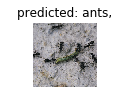

(224, 224, 3)


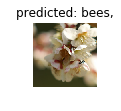

(224, 224, 3)


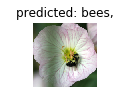

(224, 224, 3)


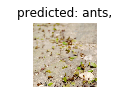

(224, 224, 3)


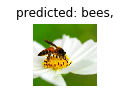

(224, 224, 3)


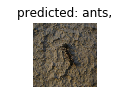

In [32]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [34]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
print(num_ftrs)
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

2048


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [35]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5539 Acc: 0.6844
val Loss: 0.2428 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4917 Acc: 0.7910
val Loss: 0.2254 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4881 Acc: 0.7787
val Loss: 0.1682 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4838 Acc: 0.7910
val Loss: 0.1611 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4074 Acc: 0.8320
val Loss: 0.1586 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5170 Acc: 0.8156
val Loss: 0.2050 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.3195 Acc: 0.8811
val Loss: 0.1532 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.2715 Acc: 0.8730
val Loss: 0.1866 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3082 Acc: 0.8730
val Loss: 0.1747 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3624 Acc: 0.8361
val Loss: 0.1774 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3262 Acc: 0.8525
val Loss: 0.1886 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2715 Acc: 0.8852
val Loss: 0.1606 Acc: 0.9346

Ep

(224, 224, 3)


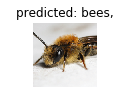

(224, 224, 3)


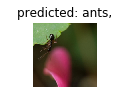

(224, 224, 3)


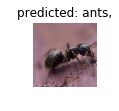

(224, 224, 3)


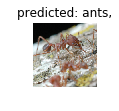

(224, 224, 3)


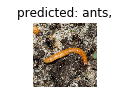

(224, 224, 3)


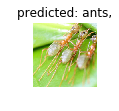

In [24]:
visualize_model(model_conv)

plt.ioff()
plt.show()